# Milestone 3 - the daTaBABES

This notebook contains our analysis of the data contained in the beer datasets from two websites BeerAdvocate (BA) and RateBeer (RB). The goal of this analysis is to answer the following question:  
**What would be the ideal beer for the US consumer depending on the month?**


In [103]:
# imports

import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go

import re
import spacy
from collections import Counter

import json

from scipy.stats import f_oneway
from sklearn import linear_model
import statsmodels.api as sm
import scipy.stats as st
import math

import hashlib

In [104]:
# Turn off warnings
import warnings

warnings.filterwarnings('ignore')

Users have rated the beers from two websites, RateBeer and BeerAdvocate, thus we get reviews of users from two distinct datasets. The reviews are in txt files, thus we convert the txt files into csv so that we can manipulate the data more easily. By doing this, we get as much as data as we can.

The conversion of the txt files into csv files is done in the notebook 'preprocessing_txt.ipynb'.

# Preprocessing

## Loading the datasets

In [105]:
# Loading the ratings datasets 
ratings_ba_df = pd.read_csv('data/BeerAdvocate/ratings_BA.csv')
ratings_rb_df = pd.read_csv('data/RateBeer/ratings_RB.csv')
ratings_matched_df = pd.read_csv('data/matched_beer_data/ratings.csv')

# Loading the users dataset 
users_ba_df = pd.read_csv('data/BeerAdvocate/users.csv')
users_rb_df = pd.read_csv('data/RateBeer/users.csv')
users_matched_df = pd.read_csv('data/matched_beer_data/users.csv')

# Loading the beers dataset
beers_ba_df = pd.read_csv('data/BeerAdvocate/beers.csv')
beers_rb_df = pd.read_csv('data/RateBeer/beers.csv')
beers_matched_df = pd.read_csv('data/matched_beer_data/beers.csv')

breweries_ba_df = pd.read_csv('data/BeerAdvocate/breweries.csv')
breweries_rb_df = pd.read_csv('data/RateBeer/breweries.csv')

In [106]:
# Convert the date column to datetime format for BeerAdvocate
ratings_ba_df['date'] = pd.to_datetime(ratings_ba_df['date'], unit='s')
ratings_ba_df['year'] = ratings_ba_df['date'].dt.year
ratings_ba_df['month'] = ratings_ba_df['date'].dt.month

# Convert the date column to datetime format for RateBeer
ratings_rb_df['date'] = pd.to_datetime(ratings_rb_df['date'], unit='s')
ratings_rb_df['year'] = ratings_rb_df['date'].dt.year
ratings_rb_df['month'] = ratings_rb_df['date'].dt.month

In [107]:
# Create a year_month column
ratings_ba_df['year_month'] = ratings_ba_df['year'].astype(str) + '-' + ratings_ba_df['month'].astype(str)
ratings_rb_df['year_month'] = ratings_rb_df['year'].astype(str) + '-' + ratings_rb_df['month'].astype(str)

# Convert the year_month column to datetime format
ratings_ba_df['year_month'] = pd.to_datetime(ratings_ba_df['year_month'])
ratings_rb_df['year_month'] = pd.to_datetime(ratings_rb_df['year_month'])


In [108]:
# Create copy of original datasets
ratings_ba_df_untouched = ratings_ba_df.copy()
ratings_rb_df_untouched = ratings_rb_df.copy()
beers_ba_df_untouched = beers_ba_df.copy()
beers_rb_df_untouched = beers_rb_df.copy()

In [109]:
# Print the number of ratings in each dataset
nbr_ratings_ba = ratings_ba_df.shape[0]
nbr_ratings_rb = ratings_rb_df.shape[0]

print('Number of ratings in BeerAdvocate: {}'.format(nbr_ratings_ba))
print('Number of ratings in RateBeer: {}'.format(nbr_ratings_rb))

Number of ratings in BeerAdvocate: 2715712
Number of ratings in RateBeer: 7122074


Names of brewery id don't match for both datasets:

In [110]:
beers_matched_df.head(2)

,ba,ba.1,ba.2,ba.3,ba.4,ba.5,ba.6,ba.7,ba.8,ba.9,...,rb.7,rb.8,rb.9,rb.10,rb.11,rb.12,rb.13,rb.14,scores,scores.1
0,abv,avg,avg_computed,avg_matched_valid_ratings,ba_score,beer_id,beer_name,beer_wout_brewery_name,brewery_id,brewery_name,...,brewery_id,brewery_name,nbr_matched_valid_ratings,nbr_ratings,overall_score,style,style_score,zscore,diff,sim
1,4.8,3.45,3.439866666666666,3.504067796610169,80.0,19827,Legbiter,Legbiter,10093,Strangford Lough Brewing Company Ltd,...,4959,Strangford Lough,89,89,23.0,Golden Ale/Blond Ale,27.0,-0.69830388113311,1.0,1.0


Names of beer styles don't match for both datasets:

In [111]:
ratings_matched_df.head(2)

,ba,ba.1,ba.2,ba.3,ba.4,ba.5,ba.6,ba.7,ba.8,ba.9,...,rb.6,rb.7,rb.8,rb.9,rb.10,rb.11,rb.12,rb.13,rb.14,rb.15
0,abv,appearance,aroma,beer_id,beer_name,brewery_id,brewery_name,date,overall,palate,...,brewery_name,date,overall,palate,rating,style,taste,text,user_id,user_name
1,11.3,4.5,4.5,645,Trappistes Rochefort 10,207,Brasserie de Rochefort,1324810800,5.0,4.5,...,Brasserie Rochefort,1387710000,19.0,4.0,4.6,Abt/Quadrupel,9.0,a) Geruch malzig-schwer-sÃ¼Ã. Riecht schon ...,83106,Erzengel


## Is the beer_id really unique ? 

By having two different datasets, we have numerous problems that could impact our analysis: 
* Do we have similar *beer_id* in the two datasets but do not represent the same beer ?
* Do we have similar *brewery_id* in the two datasets but do not represent the same beer ? 

1. Are beers really unique ? 

In [112]:
beers_ba = beers_ba_df.beer_id.unique()
beers_rb = beers_rb_df.beer_id.unique()

# Print the number of unique beers in each dataset
nbr_beers_ba = len(beers_ba)
nbr_beers_rb = len(beers_rb)

print('Number of unique beers in BeerAdvocate: {}'.format(nbr_beers_ba))
print('Number of unique beers in RateBeer: {}'.format(nbr_beers_rb))

# intersection of beers in both datasets
beers_in_both = np.intersect1d(beers_ba, beers_rb)

# Print the number of beers in both datasets
nbr_beers_in_both = len(beers_in_both)
print('Number of beers in both datasets: {}'.format(nbr_beers_in_both))

# select the first beer_id in the intersection
beer_id = beers_in_both[0]

# display the row with the beer_id in the BeerAdvocate dataset and the RateBeer dataset
print('BeerAdvocate:')
display(beers_ba_df[beers_ba_df.beer_id == beer_id])

print('RateBeer:')
display(beers_rb_df[beers_rb_df.beer_id == beer_id])

Number of unique beers in BeerAdvocate: 280823
Number of unique beers in RateBeer: 442081
Number of beers in both datasets: 220120
BeerAdvocate:


,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,nbr_reviews,avg,ba_score,bros_score,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
269762,3,Cactus Queen IPA,2,Yellow Rose Brewing Company,American IPA,3,3,4.11,NaN,90.0,NaN,4.106667,NaN,0,NaN


RateBeer:


,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,overall_score,style_score,avg,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
160124,3,Abita Andygator,1,Abita Brewing Company,Doppelbock,682,31.0,17.0,2.95,8.0,2.950293,-0.703049,682,2.950293


We observe that eventhough there are exactly 220,120 beers that have the same *beer_id* between the two datasets. If we observe one of the beer_id that appears in the same datasets, the description of the beer is not the same. This could impact our future analysis, since the analysis of the ratings would be biased. 

2. Are breweries really unique ? 

In [113]:
breweries_ba = breweries_ba_df.id.unique()
breweries_rb = breweries_rb_df.id.unique()

# Print the number of unique breweries in each dataset
nbr_breweries_ba = len(breweries_ba)
nbr_breweries_rb = len(breweries_rb)

print('Number of unique breweries in BeerAdvocate: {}'.format(nbr_breweries_ba))
print('Number of unique breweries in RateBeer: {}'.format(nbr_breweries_rb))

# intersection of breweries in both datasets
breweries_in_both = np.intersect1d(breweries_ba, breweries_rb)

# Print the number of breweries in both datasets
nbr_breweries_in_both = len(breweries_in_both)
print('Number of breweries in both datasets: {}'.format(nbr_breweries_in_both))

# select the first brewery_id in the intersection
brewery_id = breweries_in_both[0]

# display the row with the brewery_id in the BeerAdvocate dataset and the RateBeer dataset
print('BeerAdvocate:')
display(breweries_ba_df[breweries_ba_df.id == brewery_id])

print('RateBeer:')
display(breweries_rb_df[breweries_rb_df.id == brewery_id])


Number of unique breweries in BeerAdvocate: 16758
Number of unique breweries in RateBeer: 24189
Number of breweries in both datasets: 7094
BeerAdvocate:


,id,location,name,nbr_beers
6880,1,Czech Republic,Plzeňský Prazdroj,24


RateBeer:


,id,location,name,nbr_beers
13443,1,"United States, Louisiana",Abita Brewing Company,127


We can observe the same problem for the breweries. 

A first approach is to generate a new *id* with the informations of the beers. With *hashlib*, if the same information are used to compute the id in both datasets, it will be immediate to match the same beers. But, first we need to select the informations that will be used to compute the new *id* of the beer. 

Let's see in the matched dataset if the beers matched have exactly the same informations. 

3. Do the same beers have the same description in both datasets ? 

In [114]:
print('Number of ratings in the matched dataset: {}'.format(ratings_matched_df.shape[0]))

Number of ratings in the matched dataset: 21965


In [115]:
ratings_matched_df_ba = ratings_matched_df[['ba', 'ba.1', 'ba.2', 'ba.3', 'ba.4', 'ba.5', 'ba.6', 'ba.7', 'ba.8',
       'ba.9', 'ba.10', 'ba.11', 'ba.12', 'ba.13', 'ba.14', 'ba.15', 'ba.16']]

ratings_matched_df_rb = ratings_matched_df[['rb', 'rb.1', 'rb.2', 'rb.3', 'rb.4', 'rb.5', 'rb.6', 'rb.7', 'rb.8',
         'rb.9', 'rb.10', 'rb.11', 'rb.12', 'rb.13', 'rb.14', 'rb.15']]

In [116]:
# consider as the header the first row of the dataframe and drop it
ratings_matched_df_ba.columns = ratings_matched_df_ba.iloc[0]
ratings_matched_df_ba = ratings_matched_df_ba.drop(ratings_matched_df_ba.index[0])

ratings_matched_df_rb.columns = ratings_matched_df_rb.iloc[0]
ratings_matched_df_rb = ratings_matched_df_rb.drop(ratings_matched_df_rb.index[0])

In [117]:
ratings_matched_df_ba.head(2)

,abv,appearance,aroma,beer_id,beer_name,brewery_id,brewery_name,date,overall,palate,rating,review,style,taste,text,user_id,user_name
1,11.3,4.5,4.5,645,Trappistes Rochefort 10,207,Brasserie de Rochefort,1324810800,5.0,4.5,4.8,True,Quadrupel (Quad),5.0,Best before 27.07.2016Directly reviewed in com...,erzengel.248045,Erzengel
2,5.0,NaN,NaN,28191,Myanmar Lager Beer,9369,Myanmar Brewery and Distillery,1322650800,NaN,NaN,3.0,True,American Adjunct Lager,NaN,NaN,visionthing.639993,visionthing


In [118]:
ratings_matched_df_rb.head(2)

,abv,appearance,aroma,beer_id,beer_name,brewery_id,brewery_name,date,overall,palate,rating,style,taste,text,user_id,user_name
1,11.3,4.0,10.0,2360,Rochefort Trappistes 10,406,Brasserie Rochefort,1387710000,19.0,4.0,4.6,Abt/Quadrupel,9.0,a) Geruch malzig-schwer-sÃ¼Ã. Riecht schon ...,83106,Erzengel
2,5.0,2.0,3.0,17109,Myanmar Lager Beer,2921,Myanmar Brewery and Distillery,1322564400,6.0,2.0,1.7,Pale Lager,4.0,"Can. Weak and watery, not the best beer of the...",91324,visionthing


**Problems**: 
* We can generate a new *id* in both datasets for the beer with the unique attributes such as abv, beer_name and style. But, as observed above, the problem is that the style and even the beer_name does not appear the same in both datasets. Thus, we could not match the same beers when merging the two datasets. They will be considered as different beers. 
* We cannot use the matched dataset to match every beer, since the dataset only contains ratings given by same user to the same beer. 

**Solution**: 

We decide to compute a new *id* for each beer and a new *id* for each brewery as well. To do so, we use the *hashlib* function. 
* For **beer_id** : we use style, name and abv to compute the new *id*.
* For **brewery_id**: we use the name and location to compute the new *id*.

In [120]:
def generate_unique_id_beer(name, brewery_name, style, abv):
    unique_id = hashlib.sha256(f"{name}{brewery_name}{style}{abv}".encode()).hexdigest()
    return unique_id

def generate_unique_id_brewery(name, country):
    unique_id = hashlib.sha256(f"{name}{country}".encode()).hexdigest()
    return unique_id

# Create a unique id for each beer in the BeerAdvocate dataset
beers_ba_df['new_id'] = beers_ba_df.apply(lambda x: generate_unique_id_beer(x['beer_name'], x['brewery_name'], x['style'], x['abv']), axis=1)
beers_rb_df['new_id'] = beers_rb_df.apply(lambda x: generate_unique_id_beer(x['beer_name'], x['brewery_name'], x['style'], x['abv']), axis=1)

# Create a unique id for each brewery in the BeerAdvocate dataset
breweries_ba_df['new_id'] = breweries_ba_df.apply(lambda x: generate_unique_id_brewery(x['name'], x['location']), axis=1)
breweries_rb_df['new_id'] = breweries_rb_df.apply(lambda x: generate_unique_id_brewery(x['name'], x['location']), axis=1)

# create new_id_beer and new_id_brewery columns in the ratings datasets 
ratings_ba_df['new_id_beer'] = ratings_ba_df['beer_id'].map(beers_ba_df.set_index('beer_id')['new_id'])
ratings_rb_df['new_id_beer'] = ratings_rb_df['beer_id'].map(beers_rb_df.set_index('beer_id')['new_id'])

In [121]:
ratings_ba_df['new_id_brewery'] = ratings_ba_df['brewery_id'].map(breweries_ba_df.set_index('id')['new_id'])
ratings_rb_df['new_id_brewery'] = ratings_rb_df['brewery_id'].map(breweries_rb_df.set_index('id')['new_id'])

Let's verify now if we have intersected beer_ids. 

In [122]:
beers_ba = beers_ba_df.new_id.unique()
beers_rb = beers_rb_df.new_id.unique()

# Print the number of unique beers in each dataset
nbr_beers_ba = len(beers_ba)
nbr_beers_rb = len(beers_rb)

print('Number of unique beers in BeerAdvocate: {}'.format(nbr_beers_ba))
print('Number of unique beers in RateBeer: {}'.format(nbr_beers_rb))

# intersection of beers in both datasets
beers_in_both = np.intersect1d(beers_ba, beers_rb)

# Print the number of beers in both datasets
nbr_beers_in_both = len(beers_in_both)
print('Number of beers in both datasets: {}'.format(nbr_beers_in_both))

# select the first beer_id in the intersection
beer_id = beers_in_both[0]

# display the row with the beer_id in the BeerAdvocate dataset and the RateBeer dataset
print('BeerAdvocate:')
display(beers_ba_df[beers_ba_df.new_id == beer_id])

print('RateBeer:')
display(beers_rb_df[beers_rb_df.new_id == beer_id])

Number of unique beers in BeerAdvocate: 280340
Number of unique beers in RateBeer: 441961
Number of beers in both datasets: 318
BeerAdvocate:


,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,nbr_reviews,avg,ba_score,bros_score,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings,new_id
59034,22191,Texels Skuumkoppe,526,Texelse Bierbrouwerij,Dunkelweizen,63,21,3.66,83.0,NaN,6.0,3.593651,-0.620733,24,3.582917,00a12a5e8b254f5add9d2a532216a07ae07aa6f19af93f...


RateBeer:


,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,overall_score,style_score,avg,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings,new_id
122954,23569,Texels Skuumkoppe,1995,Texelse Bierbrouwerij,Dunkelweizen,264,44.0,64.0,3.12,6.0,3.138636,-0.429225,264,3.138636,00a12a5e8b254f5add9d2a532216a07ae07aa6f19af93f...


We observe here that the sample of beers in both dataset has reduced a lot. We still have 922 beers that are contained into both. If we print the description of the beers, we see that they are exactly the same. This solves our previous problem. 

Let's verify the same for brewery_id.

In [123]:
breweries_ba = breweries_ba_df.new_id.unique()
breweries_rb = breweries_rb_df.new_id.unique()

# Print the number of unique breweries in each dataset
nbr_breweries_ba = len(breweries_ba)
nbr_breweries_rb = len(breweries_rb)

print('Number of unique breweries in BeerAdvocate: {}'.format(nbr_breweries_ba))
print('Number of unique breweries in RateBeer: {}'.format(nbr_breweries_rb))

# intersection of breweries in both datasets
breweries_in_both = np.intersect1d(breweries_ba, breweries_rb)

# Print the number of breweries in both datasets
nbr_breweries_in_both = len(breweries_in_both)
print('Number of breweries in both datasets: {}'.format(nbr_breweries_in_both))

# select the first brewery_id in the intersection
brewery_id = breweries_in_both[0]

# display the row with the brewery_id in the BeerAdvocate dataset and the RateBeer dataset
print('BeerAdvocate:')
display(breweries_ba_df[breweries_ba_df.new_id == brewery_id])

print('RateBeer:')
display(breweries_rb_df[breweries_rb_df.new_id == brewery_id])

Number of unique breweries in BeerAdvocate: 16443
Number of unique breweries in RateBeer: 24185
Number of breweries in both datasets: 5912
BeerAdvocate:


,id,location,name,nbr_beers,new_id
9385,41055,"United States, Washington",Cascadia Homebrew,4,00024316aac506d29759a098a1b8f21fbb8f06aeab3f3b...


RateBeer:


,id,location,name,nbr_beers,new_id
14431,25842,"United States, Washington",Cascadia Homebrew,6,00024316aac506d29759a098a1b8f21fbb8f06aeab3f3b...


## US consumers 

To start our analysis, we look at the distribution of unique users across different countries. We would like to focus on a single country for our analysis as ratings from users from different regions can introduce mixed results that represents no country in reality. For example a certain type of beer can be appreciated in summer and not in winter. But depending on the region of the worls, summer and winter are in different time of the year. So looking at the rating of that beer for each month for each users will not showcase this particularity. By narrowing down to one country, we get a clearer picture of what people in that specific place like. This helps us avoid getting mixed results that might be affected by different tastes and seasons in different parts of the world.

In [124]:
# Extract the country from the location
users_rb_df['location'] = users_rb_df['location'].str.split(',').str[0]
users_ba_df['location'] = users_ba_df['location'].str.split(',').str[0]

In [125]:
# Number of users per country, in RateBeer
rb_user_count_country = users_rb_df.groupby('location')['location'].count().sort_values(ascending=False).reset_index(name='nb users in RateBeer')

# Number of users per country, in BeerAdvocate
ba_user_count_country = users_ba_df.groupby('location')['location'].count().sort_values(ascending=False).reset_index(name='nb users in BeerAdvocate')

In [126]:
# Merge the two above data frames to count the total number of users per country
users_country = rb_user_count_country.merge(ba_user_count_country, on='location')
users_country['total nb of users'] = users_country['nb users in RateBeer'] + users_country['nb users in BeerAdvocate']
users_country = users_country.sort_values('total nb of users', ascending=False)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'United States'),
  Text(1, 0, 'Canada'),
  Text(2, 0, 'England'),
  Text(3, 0, 'Australia'),
  Text(4, 0, 'Poland'),
  Text(5, 0, 'Netherlands'),
  Text(6, 0, 'Sweden'),
  Text(7, 0, 'Germany'),
  Text(8, 0, 'Belgium'),
  Text(9, 0, 'Denmark')])

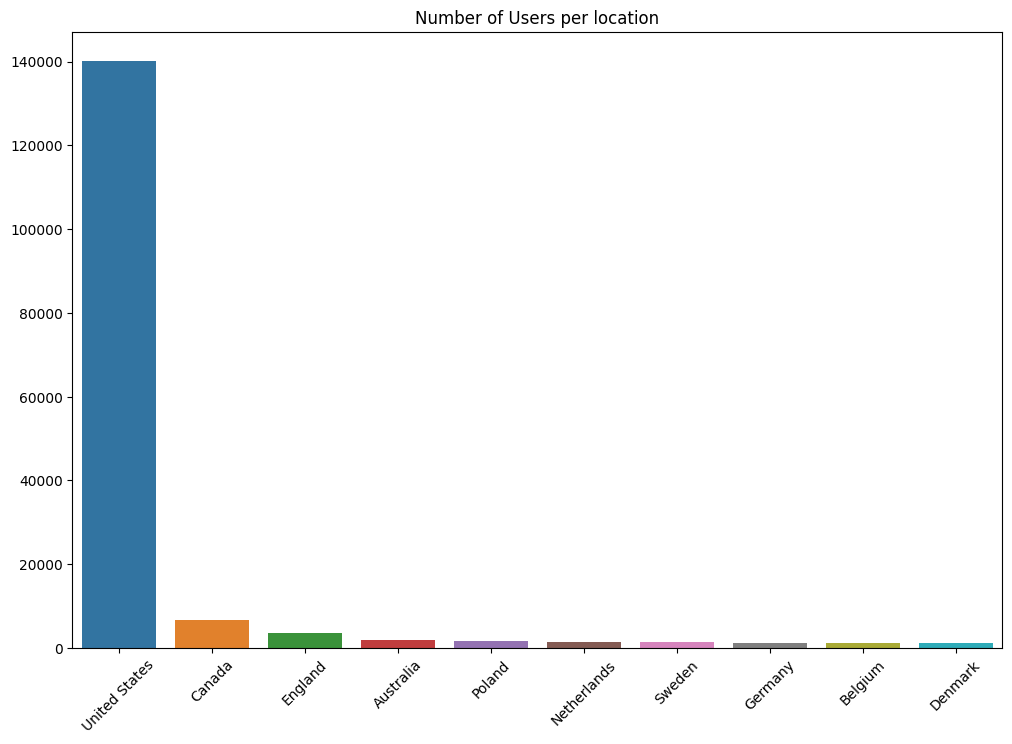

In [127]:
# Plot the distribution of the number of users per country
plt.figure(figsize=(12,8))
sns.barplot(x=users_country['location'].values[:10], y=users_country['total nb of users'].values[:10])
plt.title('Number of Users per location')
plt.xticks(rotation=45)

As we see, the US has much more users than the other countries. This leads us to think that by focusing on this country, we will get the most diverse reviews as they come from many different users. If we would consider Canada for example, we could have bias results as there are not so many users and the reviews come from a small set of people, leading us to provide a perfect beer for very few people. For this reason, our analysis will be focused on the US only.

In [128]:
US_country = 'United States'

# Keep only the rows where the user country is United States
users_ba_df_us = users_ba_df[users_ba_df.location == US_country]
users_rb_df_us = users_rb_df[users_rb_df.location == US_country]

# Keep only the rows where the user country is not from United States
users_ba_df_ca = users_ba_df[users_ba_df.location != US_country]
users_rb_df_ca = users_rb_df[users_rb_df.location != US_country]

In [129]:
# Merge the ratings and users data frames to get the location of the user for each rating
ratings_users_ba_df_us = pd.merge(ratings_ba_df, users_ba_df_us[['user_id', 'location']], on='user_id', how='inner')
ratings_users_rb_df_us = pd.merge(ratings_rb_df, users_rb_df_us[['user_id', 'location']], on='user_id', how='inner')

ratings_users_ba_df_ca = pd.merge(ratings_ba_df, users_ba_df_ca[['user_id', 'location']], on='user_id', how='inner')
ratings_users_rb_df_ca = pd.merge(ratings_rb_df, users_rb_df_ca[['user_id', 'location']], on='user_id', how='inner')

Filtered dataframe to separate ratings from US users from the rest

In [130]:
# filter the ratings dataframes to only keep ratings of the users from the US
ratings_ba_df_us = ratings_users_ba_df_us[ratings_users_ba_df_us.location == US_country]
ratings_ba_df_us.drop('location', axis=1, inplace=True)
ratings_rb_df_us = ratings_users_rb_df_us[ratings_users_rb_df_us.location == US_country]
ratings_rb_df_us.drop('location', axis=1, inplace=True)

# filter the ratings dataframes to only keep ratings of the users not from US
ratings_ba_df_ca = ratings_users_ba_df_ca[ratings_users_ba_df_ca.location != US_country]
ratings_ba_df_ca.drop('location', axis=1, inplace=True)
ratings_rb_df_ca = ratings_users_rb_df_ca[ratings_users_rb_df_ca.location != US_country]
ratings_rb_df_ca.drop('location', axis=1, inplace=True)


Number of ratings from the US in BeerAdvocate: 2346494
Number of ratings from the US in Ratebeer: 3108958
Number of ratings not from US in BeerAdvocate: 369218
Number of ratings not from US in Ratebeer: 4014825


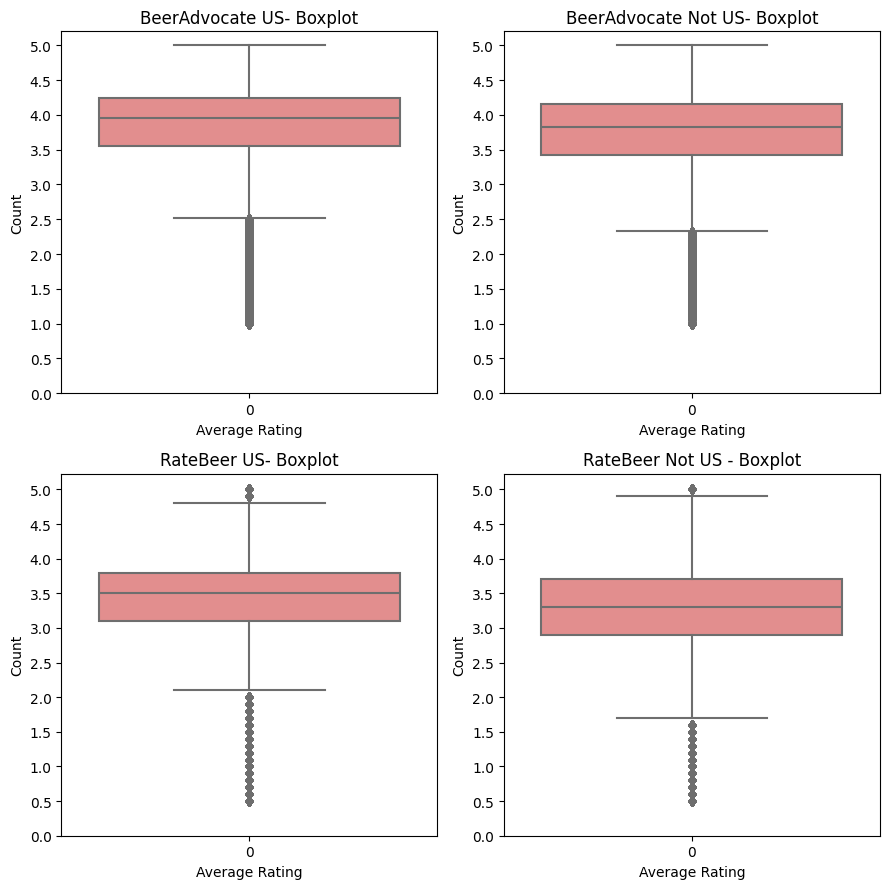

In [131]:
# Plot the distribution of the number of ratings per user
fig, axes = plt.subplots(2, 2, figsize=(9, 9))

# Number of beers in BeerAdvocate and RateBeer
print("Number of ratings from the US in BeerAdvocate:", len(ratings_ba_df_us))
print("Number of ratings from the US in Ratebeer:", len(ratings_rb_df_us))
print("Number of ratings not from US in BeerAdvocate:", len(ratings_ba_df_ca))
print("Number of ratings not from US in Ratebeer:", len(ratings_rb_df_ca))

# BeerAdvocate US- Boxplot
sns.boxplot(ratings_ba_df_us['rating'], ax=axes[0, 0], color='lightcoral')
axes[0, 0].set_xlabel('Average Rating')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('BeerAdvocate US- Boxplot')
axes[0, 0].set_yticks(np.arange(0, 5.5, 0.5))

# BeerAdvocate Not US- Boxplot
sns.boxplot(ratings_ba_df_ca['rating'], ax=axes[0, 1], color='lightcoral')
axes[0, 1].set_xlabel('Average Rating')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('BeerAdvocate Not US- Boxplot')
axes[0, 1].set_yticks(np.arange(0, 5.5, 0.5))

# RateBeer US- Boxplot
sns.boxplot(ratings_rb_df_us['rating'], ax=axes[1, 0], color='lightcoral')
axes[1, 0].set_xlabel('Average Rating')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('RateBeer US- Boxplot')
axes[1, 0].set_yticks(np.arange(0, 5.5, 0.5))

# RateBeer Not US - Boxplot
sns.boxplot(ratings_rb_df_ca['rating'], ax=axes[1, 1], color='lightcoral')
axes[1, 1].set_xlabel('Average Rating')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('RateBeer Not US - Boxplot')
axes[1, 1].set_yticks(np.arange(0, 5.5, 0.5))

plt.tight_layout()
plt.show()

### Mann-Whithney U Test
* US vs Not US:
    - Null Hypothesis (H0): There is no difference in beer ratings between the US and non-US beers.
    - Alternative Hypothesis (H1): There is a difference in beer ratings between the US and non-US beers.
* US vs US:
    - Null Hypothesis (H0): There is no difference in beer ratings between US beers.
    - Alternative Hypothesis (H1): There is a difference in beer ratings between US beers.
* Not US vs Not US:
    - Null Hypothesis (H0): There is no difference in beer ratings between non-US beers.
    - Alternative Hypothesis (H1): There is a difference in beer ratings between non-US beers.

In [132]:
# test if the ratings from the US and not from the US are from the same distribution
print('BeerAdvocate:')
print('US vs Not US')
print(st.mannwhitneyu(ratings_ba_df_us['rating'], ratings_ba_df_ca['rating']))
print('US vs US')
print(st.mannwhitneyu(ratings_ba_df_us['rating'], ratings_ba_df_us['rating']))
print('Not US vs Not US')
print(st.mannwhitneyu(ratings_ba_df_ca['rating'], ratings_ba_df_ca['rating']))

print('RateBeer:')
print('US vs Not US')
print(st.mannwhitneyu(ratings_rb_df_us['rating'], ratings_rb_df_ca['rating']))
print('US vs US')
print(st.mannwhitneyu(ratings_rb_df_us['rating'], ratings_rb_df_us['rating']))
print('Not US vs Not US')
print(st.mannwhitneyu(ratings_rb_df_ca['rating'], ratings_rb_df_ca['rating']))


BeerAdvocate:
US vs Not US
MannwhitneyuResult(statistic=481028997358.5, pvalue=0.0)
US vs US
MannwhitneyuResult(statistic=2753017046018.0, pvalue=1.0)
Not US vs Not US
MannwhitneyuResult(statistic=68160965762.0, pvalue=1.0)
RateBeer:
US vs Not US
MannwhitneyuResult(statistic=7274970199334.5, pvalue=0.0)
US vs US
MannwhitneyuResult(statistic=4832809922882.0, pvalue=1.0)
Not US vs Not US
MannwhitneyuResult(statistic=8059409890312.5, pvalue=1.0)


From the boxplot, we observe visually small differences in the distribution of the ratings between US users and non-US users. After the Mann-Whitney U Test, we significantly reject the null hypothesis for US vs Not US users, which means that the distributions are significantly different. Thus, we can focus uniquely on US users to avoid any bias in our analysis. 

Filter the datasets to only keep users from the US:

In [133]:
ratings_ba_df = ratings_ba_df_us
ratings_rb_df = ratings_rb_df_us

In [134]:
nbr_ratings_ba = ratings_ba_df.shape[0]
nbr_ratings_rb = ratings_rb_df.shape[0]

print('Number of ratings in BeerAdvocate: {}'.format(nbr_ratings_ba))
print('Number of ratings in RateBeer: {}'.format(nbr_ratings_rb))

Number of ratings in BeerAdvocate: 2346494
Number of ratings in RateBeer: 3108958


## Are there users who excessively rate a beer in a short time period ?

Motivation: we want to handle the cases where we could have many ratings from a specific user for the same beer as it could be a user that is trying to bias the rating of a particular beer

In [135]:
# Assuming ratings_combined_df is your DataFrame
threshold = 3  # Adjust this threshold based on your criteria

# Group by user_id, beer_id, and year_month, and count the number of ratings
user_beer_counts_ba = ratings_ba_df.groupby(['user_id', 'beer_id', 'year_month']).size().reset_index(name='rating_count')
user_beer_counts_rb = ratings_rb_df.groupby(['user_id', 'beer_id', 'year_month']).size().reset_index(name='rating_count')

# Filter for instances where the rating count exceeds the threshold
excessive_ratings_ba = user_beer_counts_ba[user_beer_counts_ba['rating_count'] > threshold]
excessive_ratings_rb = user_beer_counts_rb[user_beer_counts_rb['rating_count'] > threshold]

print("Excessive ratings for BeerAdvocate:")
print(excessive_ratings_ba)
print("Excessive ratings for RateBeer:")
print(excessive_ratings_rb)

Excessive ratings for BeerAdvocate:
Empty DataFrame
Columns: [user_id, beer_id, year_month, rating_count]
Index: []
Excessive ratings for RateBeer:
         user_id  beer_id year_month  rating_count
184060      3070      252 2002-11-01             5
184061      3070      403 2002-01-01             5
184062      3070      411 2002-01-01             5
184063      3070      474 2002-01-01             5
184064      3070      707 2002-01-01             5
1474422    46797       46 2007-01-01            41
1474423    46797       86 2007-03-01            41
1474424    46797       87 2007-01-01            41
1474425    46797      145 2007-01-01            41
1474426    46797      589 2007-02-01            41
1474427    46797      594 2007-02-01            41
1474428    46797      662 2007-03-01            41
1474429    46797      663 2007-03-01            41
1474430    46797      690 2007-01-01            41
1474431    46797      714 2007-01-01            41
1474432    46797      745 2007-02-01

We decided to set the threshold to 3 as rating a same beer more than 3 times per month can seem suspicious. We have identified two users in RateBeer who rated the same beer excessively within a specific month. For example, user 46797 has rated 41 times many beers each month from december 2006 to march 2007.  
Such behavior is suspicious, and as a precautionary measure, we've decided to remove these users from the dataset to keep the reliability of the ratings.

In [136]:
# Remove the suspicious users
users_to_remove = [46797, 3070]
ratings_combined_df = ratings_ba_df[~ratings_ba_df['user_id'].isin(users_to_remove)]


## What is a popular beer ?

**Popularity definition:** By popular we mean with respect to the number of **good** reviews


#### Distribution of the average rating in BeerAdvocate

In [137]:
ratings_ba_df[['appearance', 'aroma', 'palate', 'style', 'taste', 'overall', 'rating']].describe()

,appearance,aroma,palate,taste,overall,rating
count,2.310684e+06,2.310684e+06,2.310684e+06,2.310684e+06,2.310684e+06,2.346494e+06
mean,3.900441e+00,3.811440e+00,3.817201e+00,3.854748e+00,3.862540e+00,3.846907e+00
std,5.870042e-01,6.626348e-01,6.496978e-01,6.964354e-01,6.714755e-01,6.044712e-01
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,3.500000e+00,3.500000e+00,3.500000e+00,3.500000e+00,3.500000e+00,3.550000e+00
50%,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,3.950000e+00
75%,4.250000e+00,4.250000e+00,4.250000e+00,4.500000e+00,4.250000e+00,4.240000e+00
max,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00


#### Distribution of the average rating in RateBeer

In [138]:
ratings_rb_df[['appearance', 'aroma', 'palate', 'style', 'taste', 'overall', 'rating']].describe()

,appearance,aroma,palate,taste,overall,rating
count,3.108958e+06,3.108958e+06,3.108958e+06,3.108958e+06,3.108958e+06,3.108958e+06
mean,3.536766e+00,6.581593e+00,3.381866e+00,6.651427e+00,1.364188e+01,3.379354e+00
std,7.864937e-01,1.540261e+00,8.069702e-01,1.529019e+00,3.127803e+00,6.799184e-01
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,5.000000e-01
25%,3.000000e+00,6.000000e+00,3.000000e+00,6.000000e+00,1.200000e+01,3.100000e+00
50%,4.000000e+00,7.000000e+00,3.000000e+00,7.000000e+00,1.400000e+01,3.500000e+00
75%,4.000000e+00,8.000000e+00,4.000000e+00,8.000000e+00,1.600000e+01,3.800000e+00
max,5.000000e+00,1.000000e+01,5.000000e+00,1.000000e+01,2.000000e+01,5.000000e+00


Number of beers in BeerAdvocate: 2346494
Number of beers in RateBeer: 3108958


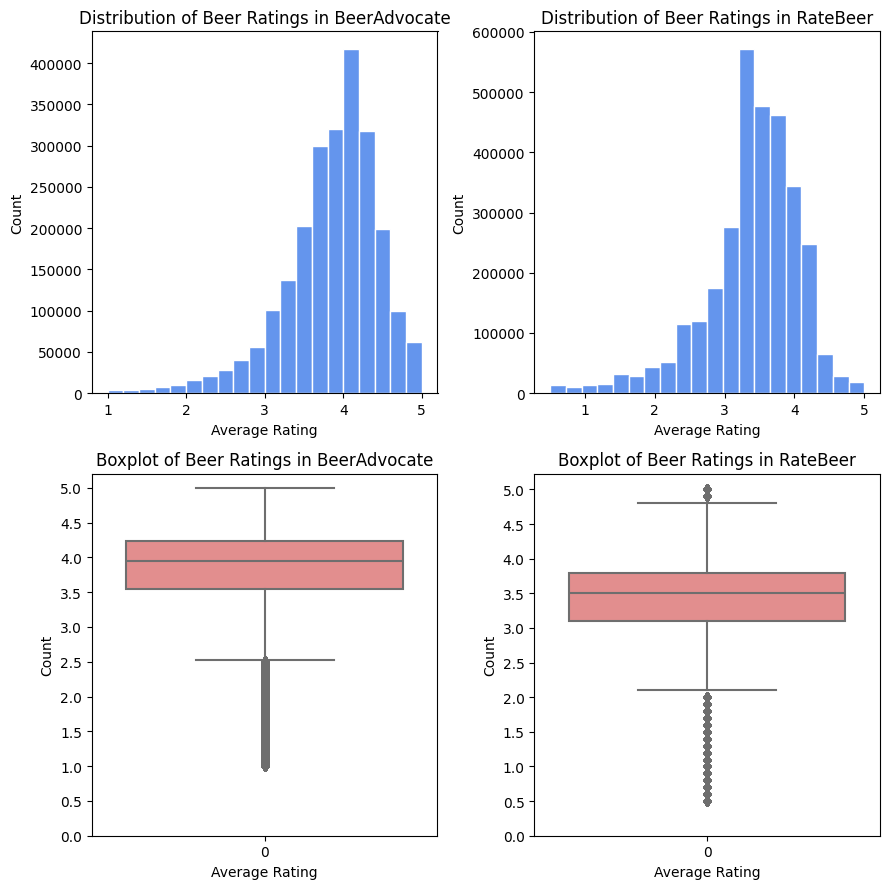

In [139]:
fig, axes = plt.subplots(2, 2, figsize=(9, 9))

# Number of beers in BeerAdvocate and RateBeer
print("Number of beers in BeerAdvocate:", len(ratings_ba_df))
print("Number of beers in RateBeer:", len(ratings_rb_df))

# BeerAdvocate - Histogram
axes[0, 0].hist(ratings_ba_df['rating'], bins=20, color='cornflowerblue', edgecolor='white')
axes[0, 0].set_xlabel('Average Rating')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Distribution of Beer Ratings in BeerAdvocate')

# RateBeer - Histogram
axes[0, 1].hist(ratings_rb_df['rating'], bins=20, color='cornflowerblue', edgecolor='white')
axes[0, 1].set_xlabel('Average Rating')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Distribution of Beer Ratings in RateBeer')
axes[0, 1].ticklabel_format(style="plain", axis="y")

# BeerAdvocate - Boxplot
sns.boxplot(ratings_ba_df['rating'], ax=axes[1, 0], color='lightcoral')
axes[1, 0].set_xlabel('Average Rating')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Boxplot of Beer Ratings in BeerAdvocate')
axes[1, 0].set_yticks(np.arange(0, 5.5, 0.5))

# RateBeer - Boxplot
sns.boxplot(ratings_rb_df['rating'], ax=axes[1, 1], color='lightcoral')
axes[1, 1].set_xlabel('Average Rating')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Boxplot of Beer Ratings in RateBeer')
axes[1, 1].set_yticks(np.arange(0, 5.5, 0.5))

plt.tight_layout()
plt.show()

In [140]:
mean_ba = ratings_ba_df.rating.mean()
mean_rb = ratings_rb_df.rating.mean()

print("Mean rating in BeerAdvocate:", mean_ba)
print("Mean rating in RateBeer:", mean_rb)

Mean rating in BeerAdvocate: 3.846906563579535
Mean rating in RateBeer: 3.3793541115704993


### T-test on the ratings of the two datasets

Let's quantify the observed results with a t-test. 

In [141]:
t_statistic, p_value = st.ttest_ind(ratings_ba_df['rating'], ratings_rb_df['rating'])

# Output the results
print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

if p_value < 0.05:
    print("The ratings in the two datasets are statistically different.")
else:
    print("There is no significant difference in the ratings between the two datasets.")


T-Statistic: 833.6675344272143
P-Value: 0.0
The ratings in the two datasets are statistically different.


As observed from the tables and the plot above, even though the distributions have a similar shape, i.e. normal distribution, they have a different average mean ratings. Indeed, users from the RateBeer dataset seem to be harsher in their ratings.

Now, as defined above, our popularity definition concerns the number of good ratings. A question that arises is: what can be considered as a good rating?

The ratings are continuous numbers between 0 to 5. One idea is to keep the ratings above the average mean of the two datasets and consider them as good rating. With this, we take in account the different distribution of the ratings into the two datasets and find a relatively good threshold.

Let's see what are the 10 most rated beer styles in each dataset:

Number of Beer Styles in AdvocateBeer: 104
Number of Beer Styles in RateBeer: 90


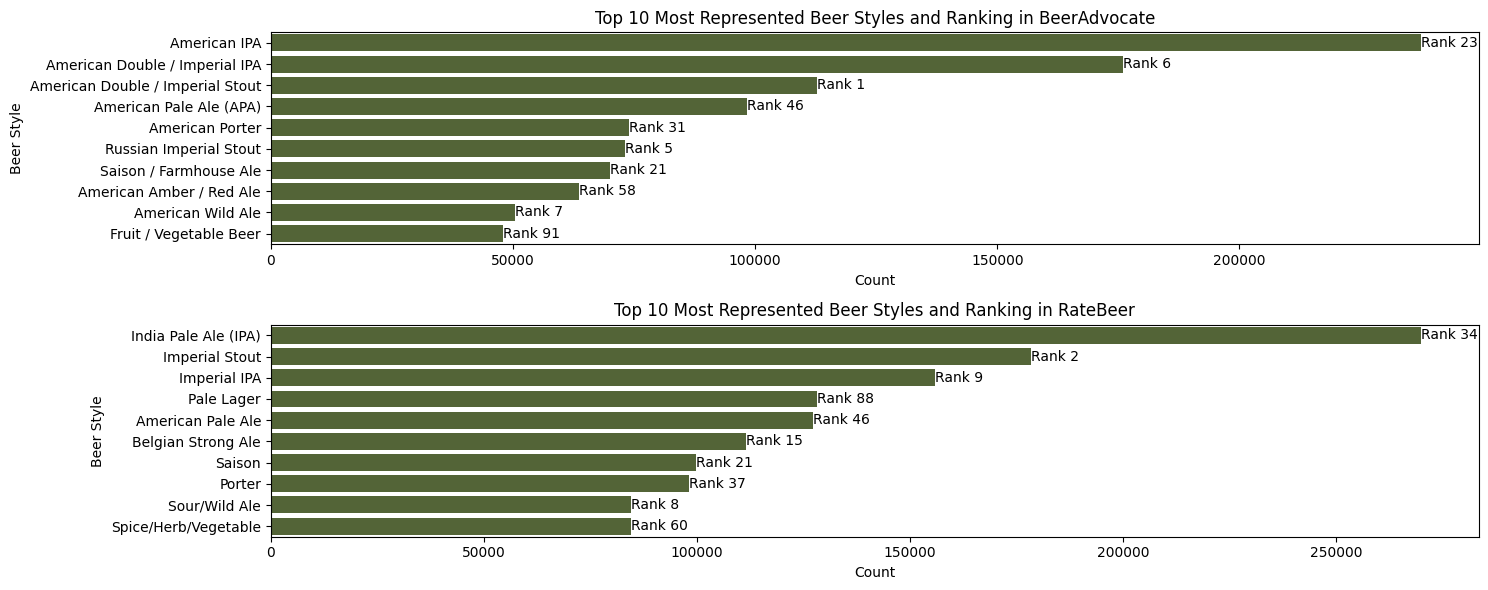

In [142]:
top_ratings_by_style_ba = ratings_ba_df.groupby('style')['rating'].mean().sort_values(ascending=False)
top_ratings_by_style_rb = ratings_rb_df.groupby('style')['rating'].mean().sort_values(ascending=False)

print(f"Number of Beer Styles in AdvocateBeer: {len(top_ratings_by_style_ba)}")
print(f"Number of Beer Styles in RateBeer: {len(top_ratings_by_style_rb)}")

# Number of top beer styles to plot
x = 10

# Create a figure with two subplots
fig, axes = plt.subplots(2, 1, figsize=(15, 6))

# BeerAdvocate
plot1 = sns.countplot(y='style', data=ratings_ba_df, order=ratings_ba_df['style'].value_counts().index[:x], color='darkolivegreen', ax=axes[0])
for i, style in enumerate(ratings_ba_df['style'].value_counts().index[:x]):
    ranking = top_ratings_by_style_ba.index.get_loc(style) + 1  
    plot1.text(ratings_ba_df['style'].value_counts()[i], i, f'Rank {ranking}', va='center')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Beer Style')
axes[0].set_title(f'Top {x} Most Represented Beer Styles and Ranking in BeerAdvocate')

# RateBeer
plot2 = sns.countplot(y='style', data=ratings_rb_df, order=ratings_rb_df['style'].value_counts().index[:x], color='darkolivegreen', ax=axes[1])
for i, style in enumerate(ratings_rb_df['style'].value_counts().index[:x]):
    ranking = top_ratings_by_style_rb.index.get_loc(style) + 1  
    plot2.text(ratings_rb_df['style'].value_counts()[i], i, f'Rank {ranking}', va='center')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Beer Style')
axes[1].set_title(f'Top {x} Most Represented Beer Styles and Ranking in RateBeer')

plt.tight_layout()
plt.show()

From the two plots above we can observe that a beer style can be popular but not have the best rating. For example in the plot of the RateBeer dataset, we see that the 3rd most popular beer style with respect to “count” is the 91th most popular beer style (over 93) when it comes to mean average rating.

## Final datasets to continue further analysis

To facilitate further analysis, we prepare a dataframe with the useful informations such as the location of the brewery and the volume of alcohol of the beer.

In [150]:
# verify if there are any duplicates in the beers dataset with the new_id column
print('Number of duplicates in BeerAdvocate:', beers_ba_df.duplicated(subset=['new_id']).sum())
print('Number of duplicates in RateBeer:', beers_rb_df.duplicated(subset=['new_id']).sum())

duplicate_beers_ba = beers_ba_df[beers_ba_df.duplicated(subset=['new_id'], keep=False)]
duplicate_beers_rb = beers_rb_df[beers_rb_df.duplicated(subset=['new_id'], keep=False)]


first_duplicate_beer_ba = duplicate_beers_ba.iloc[0]
first_duplicate_beer_rb = duplicate_beers_rb.iloc[0]

# display the row with the beer_id in the BeerAdvocate dataset and the RateBeer dataset
print('BeerAdvocate:')
display(beers_ba_df[beers_ba_df.new_id == first_duplicate_beer_ba.new_id])

print('RateBeer:')
display(beers_rb_df[beers_rb_df.new_id == first_duplicate_beer_rb.new_id])

Number of duplicates in BeerAdvocate: 483
Number of duplicates in RateBeer: 120
BeerAdvocate:


,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,nbr_reviews,avg,ba_score,bros_score,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings,new_id
6105,139099,Amber Ale,33363,Fourpure Brewing Co.,American Amber / Red Ale,5,1,3.54,NaN,NaN,5.1,3.53,NaN,0,NaN,d7c796bb27a3640cc09c61733e98c7d18ebdd978add017...
6123,165403,Amber Ale,37085,Fourpure Brewing Co.,American Amber / Red Ale,1,0,3.12,NaN,NaN,5.1,3.12,NaN,0,NaN,d7c796bb27a3640cc09c61733e98c7d18ebdd978add017...


RateBeer:


,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,overall_score,style_score,avg,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings,new_id
3159,353940,Talón de Aquiles,24064,cerartmex,Porter,0,NaN,NaN,NaN,5.0,NaN,NaN,0,NaN,4500744f834c05d1faf681aff0e097b6cf2c7b7d8c3fad...
3160,353941,Talón de Aquiles,24064,cerartmex,Porter,0,NaN,NaN,NaN,5.0,NaN,NaN,0,NaN,4500744f834c05d1faf681aff0e097b6cf2c7b7d8c3fad...


In [153]:
# verify if there are any duplicates in the breweries dataset with the new_id column
print('Number of duplicates in BeerAdvocate:', breweries_ba_df.duplicated(subset=['new_id']).sum())
print('Number of duplicates in RateBeer:', breweries_rb_df.duplicated(subset=['new_id']).sum())

duplicate_breweries_ba = breweries_ba_df[breweries_ba_df.duplicated(subset=['new_id'], keep=False)]
duplicate_breweries_rb = breweries_rb_df[breweries_rb_df.duplicated(subset=['new_id'], keep=False)]


first_duplicate_brewery_ba = duplicate_breweries_ba.iloc[0]
first_duplicate_brewery_rb = duplicate_breweries_rb.iloc[0]

# display the row with the brewery_id in the BeerAdvocate dataset and the RateBeer dataset
print('BeerAdvocate:')
display(breweries_ba_df[breweries_ba_df.new_id == first_duplicate_brewery_ba.new_id])

print('RateBeer:')
display(breweries_rb_df[breweries_rb_df.new_id == first_duplicate_brewery_rb.new_id])

Number of duplicates in BeerAdvocate: 315
Number of duplicates in RateBeer: 4
BeerAdvocate:


,id,location,name,nbr_beers,new_id
68,34598,Wales,Rhymney Brewery,2,c6df0aa690b33dca927f0cb52d0de9435a44337d8531ac...
69,12936,Wales,Rhymney Brewery,13,c6df0aa690b33dca927f0cb52d0de9435a44337d8531ac...


RateBeer:


,id,location,name,nbr_beers,new_id
1437,23620,Canada,Ridge Brewing Company,15,d1654b815d4c4fe51e802b37bd71993613aef646d6df63...
1491,3317,Canada,Ridge Brewing Company,12,d1654b815d4c4fe51e802b37bd71993613aef646d6df63...


We observe that the same beer appears multiple times in the dataset of beers description and breweries description in BeerAdvocate and RateBeer. Let's drop those duplicates. 

In [154]:
# drop the duplicates
beers_ba_df.drop_duplicates(subset=['new_id'], inplace=True)
beers_rb_df.drop_duplicates(subset=['new_id'], inplace=True)

breweries_ba_df.drop_duplicates(subset=['new_id'], inplace=True)
breweries_rb_df.drop_duplicates(subset=['new_id'], inplace=True)

In [155]:
# add column abv to the ratings datasets
ratings_ba_df['abv'] = ratings_ba_df['new_id_beer'].map(beers_ba_df.set_index('new_id')['abv'])
ratings_rb_df['abv'] = ratings_rb_df['new_id_beer'].map(beers_rb_df.set_index('new_id')['abv'])

# add column brewery_location to the ratings datasets
ratings_ba_df['brewery_location'] = ratings_ba_df['new_id_brewery'].map(breweries_ba_df.set_index('new_id')['location'])
ratings_rb_df['brewery_location'] = ratings_rb_df['new_id_brewery'].map(breweries_rb_df.set_index('new_id')['location'])

# Add column 'dataset' to the datasets to know where each row comes from orignally 
ratings_ba_df['dataset'] = 'BeerAdvocate'
ratings_rb_df['dataset'] = 'RateBeer'

# merge the two ratings dataframes
ratings_combined_df_untouched = pd.concat([ratings_ba_df_untouched, ratings_rb_df_untouched], ignore_index=True)
ratings_combined_df = pd.concat([ratings_ba_df, ratings_rb_df], ignore_index=True)

# Temporal Analysis

## General Analysis

In [158]:
def dataframe_time_analysis(df, year_lower, year_upper):
    # create a year_month column
    ratings_combined_df['year_month'] = df['year'].astype(str) + '-' + df['month'].astype(str)

    # convert the year_month column to datetime format
    ratings_combined_df['year_month'] = pd.to_datetime(ratings_combined_df['year_month'])

    # group by year_month and count the number of ratings per year_month
    year_month_ratings_count = ratings_combined_df.groupby('year_month')['year_month'].count()
    
    # creating a new dataframe with the number of ratings per year_month
    year_month_ratings_count_df = pd.DataFrame({'year_month': year_month_ratings_count.index, 'nbr_ratings': year_month_ratings_count.values})

    # create column year and month
    year_month_ratings_count_df['year'] = year_month_ratings_count_df['year_month'].dt.year
    year_month_ratings_count_df['month'] = year_month_ratings_count_df['year_month'].dt.month

    # keep only rows where the year is greater than 2011 and less than 2017 
    year_month_ratings_count_filtered = year_month_ratings_count_df[(year_month_ratings_count_df.year >= year_lower) & (year_month_ratings_count_df.year < year_upper)]

    # compute the mean number of ratings per month
    mean_ratings_per_month = year_month_ratings_count_filtered.groupby('month')['nbr_ratings'].mean().reset_index(name='mean_nbr_ratings')

    return year_month_ratings_count, year_month_ratings_count_filtered, mean_ratings_per_month 

In [159]:
year_month_ratings_count, year_month_ratings_count_filtered, mean_ratings_per_month = dataframe_time_analysis(ratings_combined_df, 2008, 2017)

# plot with plotly the mean number of ratings per month
fig = px.line(year_month_ratings_count_filtered, x='month', y='nbr_ratings', color='year', title='Mean Number of Ratings per Month (from 2008 to 2016)')
fig.add_trace(go.Scatter(x=year_month_ratings_count_filtered.month, y=mean_ratings_per_month.mean_nbr_ratings, mode='lines', name='Mean Number of Ratings', line=dict(color='black', dash='dash', width=4)))

fig.show()

From the plot above, we observe some seasonality of the beer's ratings. Indeed, we can remark that some months have some peak of ratings. The months December/January have the biggest increase. We can also see that the months of March, August and also slightly less May and October, have increases of the number of ratings. 

Let's observe the count of good ratings now. As precised above, a rating is considered as good when it is over the average mean of the dataset. 

In [160]:
# Create a new dataframe with the number of ratings per year_month
year_month_ratings_count_df = pd.DataFrame({'year_month': year_month_ratings_count.index, 'nbr_ratings': year_month_ratings_count.values})

# Create column year and month
year_month_ratings_count_df['year'] = year_month_ratings_count_df['year_month'].dt.year
year_month_ratings_count_df['month'] = year_month_ratings_count_df['year_month'].dt.month

# Keep only rows where the year is greater than 2011 and less than 2017 
year_month_ratings_count_filtered = year_month_ratings_count_df[(year_month_ratings_count_df.year >= 2008) & (year_month_ratings_count_df.year < 2017)]

# Compute the mean number of ratings per month
mean_ratings_per_month = year_month_ratings_count_filtered.groupby('month')['nbr_ratings'].mean().reset_index(name='mean_nbr_ratings')

# Plot with plotly the mean number of ratings per month
fig = px.line(year_month_ratings_count_filtered, x='month', y='nbr_ratings', color='year', title='Mean Number of Ratings per Month (from 2008 to 2016)')
fig.add_trace(go.Scatter(x=year_month_ratings_count_filtered.month, y=mean_ratings_per_month.mean_nbr_ratings, mode='lines', name='Mean Number of Ratings', line=dict(color='black', dash='dash', width=4)))

fig.show()

From the plot above, we observe some seasonality of the beer's ratings. Indeed, we can remark that some months have some peak of ratings. The months December/January have the biggest increase. We can also see that the months of March, August and also slightly less May and October, have increases of the number of ratings.

Let's observe the count of good ratings now. As precised above, a rating is considered as good when it is over the average mean of the dataset. 

In [161]:
average_ratings_ba_df = ratings_ba_df.rating.mean()
average_ratings_rb_df = ratings_rb_df.rating.mean()

print('Average rating for BeerAdvocate:', average_ratings_ba_df)
print('Average rating for RateBeer:', average_ratings_rb_df)

Average rating for BeerAdvocate: 3.846906563579535
Average rating for RateBeer: 3.3793541115704993


In [162]:
good_ratings_ba_df = ratings_ba_df[ratings_ba_df.rating >= average_ratings_ba_df]
good_ratings_rb_df = ratings_rb_df[ratings_rb_df.rating >= average_ratings_rb_df]

print('Number of good ratings for BeerAdvocate:', good_ratings_ba_df.shape[0])
print('Number of good ratings for RateBeer:', good_ratings_rb_df.shape[0])

Number of good ratings for BeerAdvocate: 1358021
Number of good ratings for RateBeer: 1863770


In [163]:
good_ratings_df = pd.concat([good_ratings_ba_df, good_ratings_rb_df], ignore_index=True)

year_month_good_ratings_count, year_month_good_ratings_count_filtered, mean_good_ratings_per_month = dataframe_time_analysis(good_ratings_df, 2008, 2017)

# plot with plotly the mean number of ratings per month
fig = px.line(year_month_good_ratings_count_filtered, x='month', y='nbr_ratings', color='year', title='Mean Number of Good Ratings per Month (from 2008 to 2016)')
fig.add_trace(go.Scatter(x=year_month_good_ratings_count_filtered.month, y=mean_good_ratings_per_month.mean_nbr_ratings, mode='lines', name='Mean Number of Good Ratings', line=dict(color='black', dash='dash', width=4)))

fig.show()

We have proved that there are some seasonality in the beer's number of ratings, and even more specifically, in the number of good ratings.

Let's quantify it by a statistical test. 

In [170]:
ratings_ba_df_copy = ratings_ba_df.copy()
ratings_rb_df_copy = ratings_rb_df.copy()

In [171]:
# add a new column "is_good" to the ratings data frame to indicate if the rating is good or not
ratings_ba_df_copy['is_good'] = ratings_ba_df_copy['rating'] >= average_ratings_ba_df
ratings_rb_df_copy['is_good'] = ratings_rb_df_copy['rating'] >= average_ratings_rb_df

ratings_ba_df_copy['is_bad'] = ratings_ba_df_copy['rating'] < average_ratings_ba_df
ratings_rb_df_copy['is_bad'] = ratings_rb_df_copy['rating'] < average_ratings_rb_df

# concatenate the two data frames
ratings_combined_df_copy = pd.concat([ratings_ba_df_copy, ratings_rb_df_copy], ignore_index=True)

# conveert to int 
ratings_combined_df_copy['is_good'] = ratings_combined_df_copy['is_good'].astype(int)
ratings_combined_df_copy['is_bad'] = ratings_combined_df_copy['is_bad'].astype(int)

In [172]:
# group by beer_id and then by year and count the number of good and bad ratings
beer_good_bad_ratings_monthly = ratings_combined_df_copy.groupby(['new_id_beer', 'month'])[['is_good', 'is_bad']].sum().reset_index()
beer_good_bad_ratings_monthly['total_nbr_ratings'] = beer_good_bad_ratings_monthly['is_good'] + beer_good_bad_ratings_monthly['is_bad']

In [173]:
# group by beer_id and then by year and count the number of good and bad ratings
beer_good_bad_ratings_yearly = ratings_combined_df_copy.groupby(['new_id_beer', 'year'])[['is_good', 'is_bad']].sum().reset_index()
beer_good_bad_ratings_yearly['total_nbr_ratings'] = beer_good_bad_ratings_yearly['is_good'] + beer_good_bad_ratings_yearly['is_bad']

In [174]:
# change name of columns 
beer_good_bad_ratings_monthly.rename(columns={'is_good': 'nbr_good_ratings', 'is_bad': 'nbr_bad_ratings'}, inplace=True)
beer_good_bad_ratings_yearly.rename(columns={'is_good': 'nbr_good_ratings', 'is_bad': 'nbr_bad_ratings'}, inplace=True)

We do a ANOVA test to see if there is any significant difference in the means of the number of good ratings across months. 

In [175]:
grouped_data = [group['nbr_good_ratings'] for _, group in beer_good_bad_ratings_monthly.groupby('month')]
result_anova, p_anova = f_oneway(*grouped_data)

print('p-value for ANOVA test:', p_anova)
print('F-statistic for ANOVA test:', result_anova)

p-value for ANOVA test: 8.421747857216745e-56
F-statistic for ANOVA test: 26.419871895827423


**Interpetation:**

* Assuming here that : 
    * Null Hypothesis: There is no significant difference in the means of the number of good ratings across months.
    * Alternative Hypothesis (H1): There is a significant difference in the means of the number of good ratings across at least two months.

* Given the very small p-value, you would reject the null hypothesis. Therefore, you have statistical evidence to conclude that there are significant differences in the means of the number of good ratings across different months. The F-statistic indicates the strength of this evidence, with a larger F-statistic supporting the rejection of the null hypothesis.

Let's observe now if there is any statistical difference between the average rating over the months 

In [176]:
# group by beer_id and then by year and count the number of good and bad ratings
beer_ratings_monthly = ratings_combined_df_copy.groupby(['new_id_beer', 'month'])['rating'].mean().reset_index()
beer_ratings_monthly.rename(columns={'rating': 'average_rating'}, inplace=True)

In [177]:
grouped_average = [group['average_rating'] for _, group in beer_ratings_monthly.groupby('month')]
result_anova, p_anova = f_oneway(*grouped_average)

print('p-value for ANOVA test:', p_anova)
print('F-statistic for ANOVA test:', result_anova)

p-value for ANOVA test: 2.6455334969582316e-145
F-statistic for ANOVA test: 64.63517229474856


**Interpetation:**

* Assuming here that : 
    * Null Hypothesis: There is no significant difference in the average ratings across months.
    * Alternative Hypothesis (H1): There is a significant difference in the average ratings across at least two months.

* Given the very small p-value, you would reject the null hypothesis. Therefore, you have statistical evidence to conclude that there are significant differences in the average ratings across different months. The F-statistic indicates the strength of this evidence, with a larger F-statistic supporting the rejection of the null hypothesis.

**Conclusion:** 
* We observe statistical significance of the number of good ratings across months. 
* We observe statistical significance of the average ratings across months. 
* Thus, we quantify the existence of seasonality of the popularity of beers. 

### Some examples

Let's now observe the average ratings per month of some Beer's style. Can we see any particular differences? Have those styles any period where the number of ratings increases?

In [181]:
sample_styles = ['Oktoberfest/Märzen', 'American Pale Ale', 'Belgian Strong Dark Ale']

for style in sample_styles: 
    ratings_users_sample = ratings_combined_df[ratings_combined_df['style'] == style]

    year_month_ratings_count, year_month_ratings_count_filtered, mean_ratings_per_month = dataframe_time_analysis(ratings_users_sample, 2008, 2017)
    
    # Plot with plotly the mean number of ratings per month
    fig = px.line(year_month_ratings_count_filtered, x='month', y='nbr_ratings', color='year', title='Mean Number of Ratings per Month for {}'.format(style))
    fig.add_trace(go.Scatter(x=year_month_ratings_count_filtered.month, y=mean_ratings_per_month.mean_nbr_ratings, mode='lines', name='Mean Number of Ratings', line=dict(color='black', dash='dash', width=4)))

    fig.show()

From the three plots, we observe big differences of the average ratings over a year. The 'Oktoberfest/Märzen' style of beers has a big increases of the ratings during the Oktoberfest period, in October. During the rest of the year, the number of ratings is low and does not fluctuates at all.

One of the most rated style is the APA, and as observed in the plot, the number of ratings does not have huge increases at some period. The style is quite popular throughout the year.

Finally the Belgian Strong Dark has a hight number of ratings around the end of the year, as observed from the mean number of ratings line.

# On the road for the perfect beer ! 